In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, glob

In [941]:
p = {}
p['beta']         = 1.0
p['alpha2']       = 0.3
p['Q_init']       = 0
p['T_learn_rate'] = 1
p['rho']          = 0.5
p['tau']          = 0.5
p['xi']           = 0.001
p['alpha2r']      = 0.70

In [942]:
class Agent:
    
    def __init__(self, **kwargs):
        
        self.__dict__.update(**kwargs)
        
        self.world = np.array([1, 10])
        
        self.num_states  = 2
        self.num_actions = 2
        
        self.Q = np.zeros(self.num_actions)
        self.T = np.full((self.num_actions, self.num_states), 1/2, dtype=float) 
        
        self.Q_history      = self.Q.copy()
        self.gain_history   = self.Q.copy()
        self.replay_history = self.Q.copy()
        self.rew_history    = []
    
    def policy(self, q_vals):
        return np.exp(q_vals*self.beta)/np.sum(np.exp(q_vals*self.beta))
    
    def compute_gain(self, exp):
    
        gain_out = np.empty(exp.shape[0])

        for i in range(exp.shape[0]):

            q_vals_before = self.Q.copy()
            q_vals_after  = self.Q.copy()

            this_exp = exp[i, :]

            probs_before = self.policy(q_vals_before)

            a = int(this_exp[0])
            r = this_exp[1]

            delta = r - q_vals_after[a]
            q_vals_after[a] = q_vals_after[a] + self.alpha2*delta

            probs_after = self.policy(q_vals_after)

            EV_pre = np.sum(probs_before*q_vals_after)
            EV_post = np.sum(probs_after*q_vals_after)

            gain_out[i] = (EV_post - EV_pre)

        return gain_out
    
    def replay(self):
        
        exp = np.array([[0, 0], [1, 0]])
        for i in range(exp.shape[0]):
            exp[i, 1] = np.dot(self.T[i, :], self.world)
        
        gain = self.compute_gain(exp)
        self.gain_history = np.vstack((self.gain_history, gain))
        
        replays = np.zeros(2)
        
        while True:
            gain = self.compute_gain(exp)
            evb  = gain/2
            
            max_idx = evb.argmax()
            
            if evb[max_idx] > self.xi:

                was_replay = True
                curr_path = exp[max_idx, :]

                ar        = int(curr_path[0])
                rr        = curr_path[1]
                
                Q_target = rr

                delta = Q_target - self.Q[ar]
                self.Q[ar] = self.Q[ar] + self.alpha2 * delta
                
                replays[ar] += 1
                
            else: 
                self.replay_history = np.vstack((self.replay_history, replays))
                return None
    
    def one_move(self, states):
        
        num_trials = len(states)
        
        for si in range(len(states)):
            
            s = states[si]
            
            probs  = self.policy(self.Q)
            a      = np.random.choice(range(self.num_actions), p=probs)
            
            r      = self.world[a]
            
            self.rew_history += [r]

            # Update Q values
            Q_target  = r        
            delta     = Q_target - self.Q[a]
            self.Q[a] = self.Q[a] + self.alpha2 * delta
            
            self.Q_history = np.vstack((self.Q_history, self.Q))
            
            # Update the state transition model
            delta_t = 1 - self.T[a, a]
            self.T[a, a] += self.T_learn_rate * delta_t

            # Normalise the transition matrix
            for i in range(self.T.shape[0]):
                row = self.T[i, :]
                tmp = np.sum(row)
                if tmp > 0:
                    self.T[i, :] = row / tmp
                
            self.replay()
            
            av_rew = np.mean(self.rew_history)
            dist   = (self.Q - av_rew)
            self.Q = self.Q - (1-self.tau)*dist

            # Forget the state transition model
            self.T = self.rho * self.T + (1-self.rho) * 1/7

            # Normalise the transition matrix
            for i in range(self.T.shape[0]):
                row = self.T[i, :]
                tmp = np.sum(row)
                if tmp > 0:
                    self.T[i, :] = row / tmp

In [15]:
np.random.seed(2)
states = np.random.randint(0, 2, size=150)

In [16]:
num_seeds = 50
r_ag      = np.zeros((num_seeds, len(states)))
g_opt     = np.zeros((num_seeds, len(states)))
g_subopt  = np.zeros((num_seeds, len(states)))
q_opt     = np.zeros((num_seeds, len(states)))
q_subopt  = np.zeros((num_seeds, len(states)))
r_opt     = np.zeros((num_seeds, len(states)))
r_subopt  = np.zeros((num_seeds, len(states)))

In [945]:
for sid in range(num_seeds):
    np.random.seed(sid)
    a    = Agent(**p)
    a.one_move(states)
    r_ag[sid, :]     = a.rew_history
    g_opt[sid, :]    = a.gain_history[1:, 1]
    g_subopt[sid, :] = a.gain_history[1:, 0]
    q_opt[sid, :]    = a.Q_history[1:, 1]
    q_subopt[sid, :] = a.Q_history[1:, 0]
    r_opt[sid, :]    = a.replay_history[1:, 1]
    r_subopt[sid, :] = a.replay_history[1:, 0]

In [946]:
perf_opt = np.ones(len(states))*10

perf = np.zeros((num_seeds, len(states)))
for sid in range(num_seeds):
    for s in range(1, len(states)):
        perf[sid, s] += [np.sum(r_ag[sid, :s])/np.sum(perf_opt[:s])]

sem  = np.std(perf, axis=0)/np.sqrt(num_seeds)

In [947]:
save_folder = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Data/didactic'

add = '_mf_mb_replay'
np.save(os.path.join(save_folder, 'q_learning%s.npy'%add), perf)
np.save(os.path.join(save_folder, 'gain_opt%s.npy'%add), g_opt)
np.save(os.path.join(save_folder, 'gain_subopt%s.npy'%add), g_subopt)
np.save(os.path.join(save_folder, 'q_opt%s.npy'%add), q_opt)
np.save(os.path.join(save_folder, 'q_subopt%s.npy'%add), q_subopt)
np.save(os.path.join(save_folder, 'r_opt%s.npy'%add), r_opt)
np.save(os.path.join(save_folder, 'r_subopt%s.npy'%add), r_subopt)

In [18]:
def plot_p(ax, to_plot):
    n = 60
    for i in range(len(to_plot)):
        name      = to_plot[i]
        perf      = np.load(os.path.join(save_folder, name))
        mean_perf = np.mean(perf[:, :n], axis=0)
        sem       = 1.96*np.std(perf[:, :n], axis=0)/np.sqrt(num_seeds)
        ax.fill_between(range(len(states[:n])), mean_perf-sem, mean_perf+sem, alpha=0.3)
        ax.plot(mean_perf, label=name.split('/')[-1][:-4])
    ax.legend(prop={'size':9}, loc='lower right')
    ax.set_xlim(0, len(mean_perf))
    ax.set_ylim(0.48, 1.02)
    ax.set_ylabel('Performance', fontsize=12)
    ax.set_xlabel('Trial', fontsize=12)
    
def plot_g(ax, to_plot):
    n = 60
    for i in to_plot:
        perf      = np.load(os.path.join(save_folder, i))
        mean_perf = np.mean(perf[:, :n], axis=0)
        sem       = 1.96*np.std(perf[:, :n], axis=0)/np.sqrt(num_seeds)
        if 'subopt' in i:
            col = 'b'
        else:
            col = 'orange'
        ax.fill_between(range(len(states[:n])), mean_perf-sem, mean_perf+sem, alpha=0.3, facecolor=col)
        ax.plot(mean_perf, label=i.split('/')[-1][:-4], c=col)
#     ax.legend(prop={'size':9}, loc='upper right')
    ax.axhline(0, c='k')
    ax.set_xlim(0, len(mean_perf))
    ax.set_ylim(-0.15, 0.26)

def plot_r(ax, to_plot):
    n = 60
    for i in to_plot:
        perf      = np.load(os.path.join(save_folder, i))
        mean_perf = np.mean(perf[:, :n], axis=0)
        sem       = 1.96*np.std(perf[:, :n], axis=0)/np.sqrt(num_seeds)
        if 'subopt' in i:
            col = 'b'
        else:
            col = 'orange'
        ax.fill_between(range(len(states[:n])), mean_perf-sem, mean_perf+sem, alpha=0.3, facecolor=col)
        ax.plot(mean_perf, label=i.split('/')[-1][:-4], c=col)
#     ax.legend(prop={'size':9})
    ax.set_xlim(0, len(mean_perf))
    ax.set_ylim(-0.5, 11)
    
def plot_q(ax, to_plot):
    n = 60
    for i in to_plot:
        perf      = np.load(os.path.join(save_folder, i))
        mean_perf = np.mean(perf[:, :n], axis=0)
        sem       = 1.96*np.std(perf[:, :n], axis=0)/np.sqrt(num_seeds)
        if 'subopt' in i:
            col = 'b'
        else:
            col = 'orange'
        ax.fill_between(range(len(states[:n])), mean_perf-sem, mean_perf+sem, alpha=0.3, facecolor=col)
        ax.plot(mean_perf, label=i.split('/')[-1][:-4], c=col)
#     ax.legend(prop={'size':9})
    ax.axhline(1, c='k')
    ax.axhline(10, c='k')
    ax.set_xlim(0, len(mean_perf))
    ax.set_ylim(-0.5, 11)

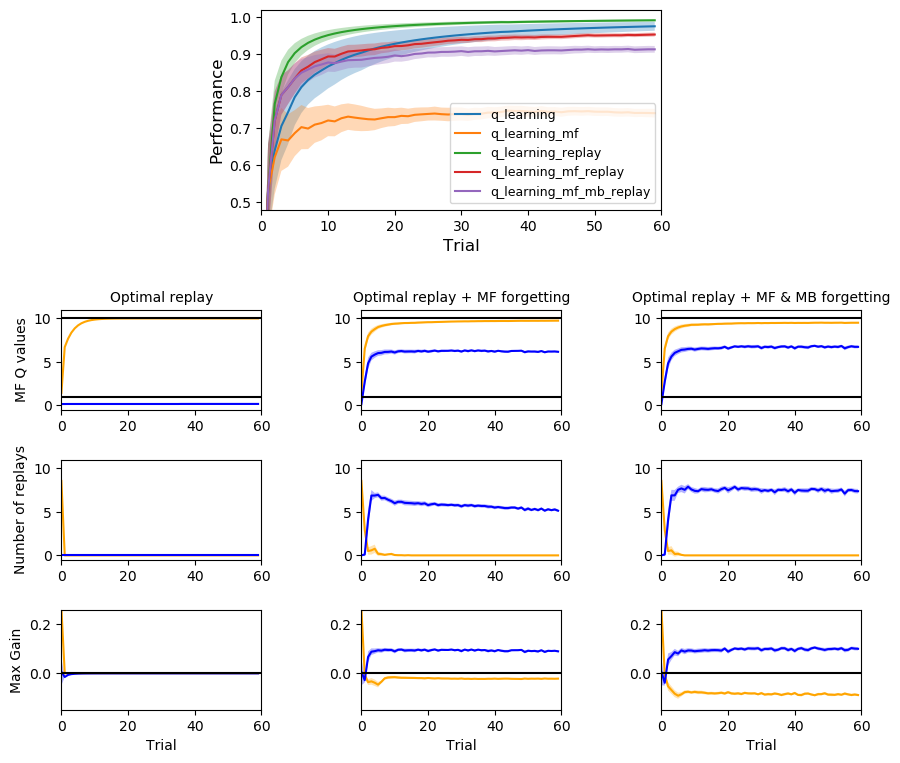

In [20]:
fig     = plt.figure(figsize=(10, 10), dpi=100)
axp     = fig.add_axes([0.25, 0.75, 0.40, 0.20]) #(left, bottom, width, height)

plot_p(axp, ['q_learning.npy', 'q_learning_mf.npy', 'q_learning_replay.npy', \
             'q_learning_mf_replay.npy', 'q_learning_mf_mb_replay.npy'])

ax1q    = fig.add_axes([0.05, 0.55, 0.20, 0.10])
plot_q(ax1q, ['q_opt_replay.npy', 'q_subopt_replay.npy'])
ax1q.set_ylabel('MF Q values')
ax1q.set_title('Optimal replay', fontsize=10)
ax2q    = fig.add_axes([0.35, 0.55, 0.20, 0.10])
plot_q(ax2q, ['q_opt_mf_replay.npy', 'q_subopt_mf_replay.npy'])
ax2q.set_title('Optimal replay + MF forgetting', fontsize=10)
ax3q    = fig.add_axes([0.65, 0.55, 0.20, 0.10])
plot_q(ax3q, ['q_opt_mf_mb_replay.npy', 'q_subopt_mf_mb_replay.npy'])
ax3q.set_title('Optimal replay + MF & MB forgetting', fontsize=10)

ax1r    = fig.add_axes([0.05, 0.40, 0.20, 0.10])
plot_r(ax1r, ['r_opt_replay.npy', 'r_subopt_replay.npy'])
ax1r.set_ylabel('Number of replays')
ax2r    = fig.add_axes([0.35, 0.40, 0.20, 0.10])
plot_r(ax2r, ['r_opt_mf_replay.npy', 'r_subopt_mf_replay.npy'])
ax3r    = fig.add_axes([0.65, 0.40, 0.20, 0.10])
plot_r(ax3r, ['r_opt_mf_mb_replay.npy', 'r_subopt_mf_mb_replay.npy'])

ax1g    = fig.add_axes([0.05, 0.25, 0.20, 0.10])
plot_g(ax1g, ['gain_opt_replay.npy', 'gain_subopt_replay.npy'])
ax1g.set_ylabel('Max Gain')
ax1g.set_xlabel('Trial')
ax2g    = fig.add_axes([0.35, 0.25, 0.20, 0.10])
plot_g(ax2g, ['gain_opt_mf_replay.npy', 'gain_subopt_mf_replay.npy'])
ax2g.set_xlabel('Trial')
ax3g    = fig.add_axes([0.65, 0.25, 0.20, 0.10])
plot_g(ax3g, ['gain_opt_mf_mb_replay.npy', 'gain_subopt_mf_mb_replay.npy'])
ax3g.set_xlabel('Trial')

# plt.savefig('/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Figures/new_fig.svg', \
#             format='svg', transparent=True)